In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import time
import scipy as sp
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
%matplotlib inline
pd.options.mode.chained_assignment = None  #close copy warning   

import numpy as np
import pandas as pd
import seaborn as sns
import folium
import time
import os
import scipy as sp
from shapely.geometry import Point
import geopandas as gpd
import datetime
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
%matplotlib inline

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif, VarianceThreshold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
# read rental data
path = os.getcwd().replace("notebooks","") + "data/curated/"
df = pd.read_csv(path+'rental_median.csv', low_memory = True)
df = df.drop_duplicates()
df = df[['Suburb','Rental_total_Mar_2000_1b_flat', 'Rental_total_Jun_2000_1b_flat', 'Rental_total_Sep_2000_1b_flat', 'Rental_total_Dec_2000_1b_flat', 'Rental_total_Mar_2001_1b_flat', 'Rental_total_Jun_2001_1b_flat', 'Rental_total_Sep_2001_1b_flat', 'Rental_total_Dec_2001_1b_flat', 'Rental_total_Mar_2002_1b_flat', 'Rental_total_Jun_2002_1b_flat', 'Rental_total_Sep_2002_1b_flat', 'Rental_total_Dec_2002_1b_flat', 'Rental_total_Mar_2003_1b_flat', 'Rental_total_Jun_2003_1b_flat', 'Rental_total_Sep_2003_1b_flat', 'Rental_total_Dec_2003_1b_flat', 'Rental_total_Mar_2004_1b_flat', 'Rental_total_Jun_2004_1b_flat', 'Rental_total_Sep_2004_1b_flat', 'Rental_total_Dec_2004_1b_flat', 'Rental_total_Mar_2005_1b_flat', 'Rental_total_Jun_2005_1b_flat', 'Rental_total_Sep_2005_1b_flat', 'Rental_total_Dec_2005_1b_flat', 'Rental_total_Mar_2006_1b_flat', 'Rental_total_Jun_2006_1b_flat', 'Rental_total_Sep_2006_1b_flat', 'Rental_total_Dec_2006_1b_flat', 'Rental_total_Mar_2007_1b_flat', 'Rental_total_Jun_2007_1b_flat', 'Rental_total_Sep_2007_1b_flat', 'Rental_total_Dec_2007_1b_flat', 'Rental_total_Mar_2008_1b_flat', 'Rental_total_Jun_2008_1b_flat', 'Rental_total_Sep_2008_1b_flat', 'Rental_total_Dec_2008_1b_flat', 'Rental_total_Mar_2009_1b_flat', 'Rental_total_Jun_2009_1b_flat', 'Rental_total_Sep_2009_1b_flat', 'Rental_total_Dec_2009_1b_flat', 'Rental_total_Mar_2010_1b_flat', 'Rental_total_Jun_2010_1b_flat', 'Rental_total_Sep_2010_1b_flat', 'Rental_total_Dec_2010_1b_flat', 'Rental_total_Mar_2011_1b_flat', 'Rental_total_Jun_2011_1b_flat', 'Rental_total_Sep_2011_1b_flat', 'Rental_total_Dec_2011_1b_flat', 'Rental_total_Mar_2012_1b_flat', 'Rental_total_Jun_2012_1b_flat', 'Rental_total_Sep_2012_1b_flat', 'Rental_total_Dec_2012_1b_flat', 'Rental_total_Mar_2013_1b_flat', 'Rental_total_Jun_2013_1b_flat', 'Rental_total_Sep_2013_1b_flat', 'Rental_total_Dec_2013_1b_flat', 'Rental_total_Mar_2014_1b_flat', 'Rental_total_Jun_2014_1b_flat', 'Rental_total_Sep_2014_1b_flat', 'Rental_total_Dec_2014_1b_flat', 'Rental_total_Mar_2015_1b_flat', 'Rental_total_Jun_2015_1b_flat', 'Rental_total_Sep_2015_1b_flat', 'Rental_total_Dec_2015_1b_flat', 'Rental_total_Mar_2016_1b_flat', 'Rental_total_Jun_2016_1b_flat', 'Rental_total_Sep_2016_1b_flat', 'Rental_total_Dec_2016_1b_flat', 'Rental_total_Mar_2017_1b_flat', 'Rental_total_Jun_2017_1b_flat', 'Rental_total_Sep_2017_1b_flat', 'Rental_total_Dec_2017_1b_flat', 'Rental_total_Mar_2018_1b_flat', 'Rental_total_Jun_2018_1b_flat', 'Rental_total_Sep_2018_1b_flat', 'Rental_total_Dec_2018_1b_flat', 'Rental_total_Mar_2019_1b_flat', 'Rental_total_Jun_2019_1b_flat', 'Rental_total_Sep_2019_1b_flat', 'Rental_total_Dec_2019_1b_flat', 'Rental_total_Mar_2020_1b_flat', 'Rental_total_Jun_2020_1b_flat', 'Rental_total_Sep_2020_1b_flat', 'Rental_total_Dec_2020_1b_flat', 'Rental_total_Mar_2021_1b_flat', 'Rental_total_Jun_2021_1b_flat', 'Rental_total_Mar_2000_2b_flat', 'Rental_total_Jun_2000_2b_flat', 'Rental_total_Sep_2000_2b_flat', 'Rental_total_Dec_2000_2b_flat', 'Rental_total_Mar_2001_2b_flat', 'Rental_total_Jun_2001_2b_flat', 'Rental_total_Sep_2001_2b_flat', 'Rental_total_Dec_2001_2b_flat', 'Rental_total_Mar_2002_2b_flat', 'Rental_total_Jun_2002_2b_flat', 'Rental_total_Sep_2002_2b_flat', 'Rental_total_Dec_2002_2b_flat', 'Rental_total_Mar_2003_2b_flat', 'Rental_total_Jun_2003_2b_flat', 'Rental_total_Sep_2003_2b_flat', 'Rental_total_Dec_2003_2b_flat', 'Rental_total_Mar_2004_2b_flat', 'Rental_total_Jun_2004_2b_flat', 'Rental_total_Sep_2004_2b_flat', 'Rental_total_Dec_2004_2b_flat', 'Rental_total_Mar_2005_2b_flat', 'Rental_total_Jun_2005_2b_flat', 'Rental_total_Sep_2005_2b_flat', 'Rental_total_Dec_2005_2b_flat', 'Rental_total_Mar_2006_2b_flat', 'Rental_total_Jun_2006_2b_flat', 'Rental_total_Sep_2006_2b_flat', 'Rental_total_Dec_2006_2b_flat', 'Rental_total_Mar_2007_2b_flat', 'Rental_total_Jun_2007_2b_flat', 'Rental_total_Sep_2007_2b_flat', 'Rental_total_Dec_2007_2b_flat', 'Rental_total_Mar_2008_2b_flat', 'Rental_total_Jun_2008_2b_flat', 'Rental_total_Sep_2008_2b_flat', 'Rental_total_Dec_2008_2b_flat', 'Rental_total_Mar_2009_2b_flat', 'Rental_total_Jun_2009_2b_flat', 'Rental_total_Sep_2009_2b_flat', 'Rental_total_Dec_2009_2b_flat', 'Rental_total_Mar_2010_2b_flat', 'Rental_total_Jun_2010_2b_flat', 'Rental_total_Sep_2010_2b_flat', 'Rental_total_Dec_2010_2b_flat', 'Rental_total_Mar_2011_2b_flat', 'Rental_total_Jun_2011_2b_flat', 'Rental_total_Sep_2011_2b_flat', 'Rental_total_Dec_2011_2b_flat', 'Rental_total_Mar_2012_2b_flat', 'Rental_total_Jun_2012_2b_flat', 'Rental_total_Sep_2012_2b_flat', 'Rental_total_Dec_2012_2b_flat', 'Rental_total_Mar_2013_2b_flat', 'Rental_total_Jun_2013_2b_flat', 'Rental_total_Sep_2013_2b_flat', 'Rental_total_Dec_2013_2b_flat', 'Rental_total_Mar_2014_2b_flat', 'Rental_total_Jun_2014_2b_flat', 'Rental_total_Sep_2014_2b_flat', 'Rental_total_Dec_2014_2b_flat', 'Rental_total_Mar_2015_2b_flat', 'Rental_total_Jun_2015_2b_flat', 'Rental_total_Sep_2015_2b_flat', 'Rental_total_Dec_2015_2b_flat', 'Rental_total_Mar_2016_2b_flat', 'Rental_total_Jun_2016_2b_flat', 'Rental_total_Sep_2016_2b_flat', 'Rental_total_Dec_2016_2b_flat', 'Rental_total_Mar_2017_2b_flat', 'Rental_total_Jun_2017_2b_flat', 'Rental_total_Sep_2017_2b_flat', 'Rental_total_Dec_2017_2b_flat', 'Rental_total_Mar_2018_2b_flat', 'Rental_total_Jun_2018_2b_flat', 'Rental_total_Sep_2018_2b_flat', 'Rental_total_Dec_2018_2b_flat', 'Rental_total_Mar_2019_2b_flat', 'Rental_total_Jun_2019_2b_flat', 'Rental_total_Sep_2019_2b_flat', 'Rental_total_Dec_2019_2b_flat', 'Rental_total_Mar_2020_2b_flat', 'Rental_total_Jun_2020_2b_flat', 'Rental_total_Sep_2020_2b_flat', 'Rental_total_Dec_2020_2b_flat', 'Rental_total_Mar_2021_2b_flat', 'Rental_total_Jun_2021_2b_flat', 'Rental_total_Mar_2000_3b_flat', 'Rental_total_Jun_2000_3b_flat', 'Rental_total_Sep_2000_3b_flat', 'Rental_total_Dec_2000_3b_flat', 'Rental_total_Mar_2001_3b_flat', 'Rental_total_Jun_2001_3b_flat', 'Rental_total_Sep_2001_3b_flat', 'Rental_total_Dec_2001_3b_flat', 'Rental_total_Mar_2002_3b_flat', 'Rental_total_Jun_2002_3b_flat', 'Rental_total_Sep_2002_3b_flat', 'Rental_total_Dec_2002_3b_flat', 'Rental_total_Mar_2003_3b_flat', 'Rental_total_Jun_2003_3b_flat', 'Rental_total_Sep_2003_3b_flat', 'Rental_total_Dec_2003_3b_flat', 'Rental_total_Mar_2004_3b_flat', 'Rental_total_Jun_2004_3b_flat', 'Rental_total_Sep_2004_3b_flat', 'Rental_total_Dec_2004_3b_flat', 'Rental_total_Mar_2005_3b_flat', 'Rental_total_Jun_2005_3b_flat', 'Rental_total_Sep_2005_3b_flat', 'Rental_total_Dec_2005_3b_flat', 'Rental_total_Mar_2006_3b_flat', 'Rental_total_Jun_2006_3b_flat', 'Rental_total_Sep_2006_3b_flat', 'Rental_total_Dec_2006_3b_flat', 'Rental_total_Mar_2007_3b_flat', 'Rental_total_Jun_2007_3b_flat', 'Rental_total_Sep_2007_3b_flat', 'Rental_total_Dec_2007_3b_flat', 'Rental_total_Mar_2008_3b_flat', 'Rental_total_Jun_2008_3b_flat', 'Rental_total_Sep_2008_3b_flat', 'Rental_total_Dec_2008_3b_flat', 'Rental_total_Mar_2009_3b_flat', 'Rental_total_Jun_2009_3b_flat', 'Rental_total_Sep_2009_3b_flat', 'Rental_total_Dec_2009_3b_flat', 'Rental_total_Mar_2010_3b_flat', 'Rental_total_Jun_2010_3b_flat', 'Rental_total_Sep_2010_3b_flat', 'Rental_total_Dec_2010_3b_flat', 'Rental_total_Mar_2011_3b_flat', 'Rental_total_Jun_2011_3b_flat', 'Rental_total_Sep_2011_3b_flat', 'Rental_total_Dec_2011_3b_flat', 'Rental_total_Mar_2012_3b_flat', 'Rental_total_Jun_2012_3b_flat', 'Rental_total_Sep_2012_3b_flat', 'Rental_total_Dec_2012_3b_flat', 'Rental_total_Mar_2013_3b_flat', 'Rental_total_Jun_2013_3b_flat', 'Rental_total_Sep_2013_3b_flat', 'Rental_total_Dec_2013_3b_flat', 'Rental_total_Mar_2014_3b_flat', 'Rental_total_Jun_2014_3b_flat', 'Rental_total_Sep_2014_3b_flat', 'Rental_total_Dec_2014_3b_flat', 'Rental_total_Mar_2015_3b_flat', 'Rental_total_Jun_2015_3b_flat', 'Rental_total_Sep_2015_3b_flat', 'Rental_total_Dec_2015_3b_flat', 'Rental_total_Mar_2016_3b_flat', 'Rental_total_Jun_2016_3b_flat', 'Rental_total_Sep_2016_3b_flat', 'Rental_total_Dec_2016_3b_flat', 'Rental_total_Mar_2017_3b_flat', 'Rental_total_Jun_2017_3b_flat', 'Rental_total_Sep_2017_3b_flat', 'Rental_total_Dec_2017_3b_flat', 'Rental_total_Mar_2018_3b_flat', 'Rental_total_Jun_2018_3b_flat', 'Rental_total_Sep_2018_3b_flat', 'Rental_total_Dec_2018_3b_flat', 'Rental_total_Mar_2019_3b_flat', 'Rental_total_Jun_2019_3b_flat', 'Rental_total_Sep_2019_3b_flat', 'Rental_total_Dec_2019_3b_flat', 'Rental_total_Mar_2020_3b_flat', 'Rental_total_Jun_2020_3b_flat', 'Rental_total_Sep_2020_3b_flat', 'Rental_total_Dec_2020_3b_flat', 'Rental_total_Mar_2021_3b_flat', 'Rental_total_Jun_2021_3b_flat', 'Rental_total_Mar_2000_2b_house', 'Rental_total_Jun_2000_2b_house', 'Rental_total_Sep_2000_2b_house', 'Rental_total_Dec_2000_2b_house', 'Rental_total_Mar_2001_2b_house', 'Rental_total_Jun_2001_2b_house', 'Rental_total_Sep_2001_2b_house', 'Rental_total_Dec_2001_2b_house', 'Rental_total_Mar_2002_2b_house', 'Rental_total_Jun_2002_2b_house', 'Rental_total_Sep_2002_2b_house', 'Rental_total_Dec_2002_2b_house', 'Rental_total_Mar_2003_2b_house', 'Rental_total_Jun_2003_2b_house', 'Rental_total_Sep_2003_2b_house', 'Rental_total_Dec_2003_2b_house', 'Rental_total_Mar_2004_2b_house', 'Rental_total_Jun_2004_2b_house', 'Rental_total_Sep_2004_2b_house', 'Rental_total_Dec_2004_2b_house', 'Rental_total_Mar_2005_2b_house', 'Rental_total_Jun_2005_2b_house', 'Rental_total_Sep_2005_2b_house', 'Rental_total_Dec_2005_2b_house', 'Rental_total_Mar_2006_2b_house', 'Rental_total_Jun_2006_2b_house', 'Rental_total_Sep_2006_2b_house', 'Rental_total_Dec_2006_2b_house', 'Rental_total_Mar_2007_2b_house', 'Rental_total_Jun_2007_2b_house', 'Rental_total_Sep_2007_2b_house', 'Rental_total_Dec_2007_2b_house', 'Rental_total_Mar_2008_2b_house', 'Rental_total_Jun_2008_2b_house', 'Rental_total_Sep_2008_2b_house', 'Rental_total_Dec_2008_2b_house', 'Rental_total_Mar_2009_2b_house', 'Rental_total_Jun_2009_2b_house', 'Rental_total_Sep_2009_2b_house', 'Rental_total_Dec_2009_2b_house', 'Rental_total_Mar_2010_2b_house', 'Rental_total_Jun_2010_2b_house', 'Rental_total_Sep_2010_2b_house', 'Rental_total_Dec_2010_2b_house', 'Rental_total_Mar_2011_2b_house', 'Rental_total_Jun_2011_2b_house', 'Rental_total_Sep_2011_2b_house', 'Rental_total_Dec_2011_2b_house', 'Rental_total_Mar_2012_2b_house', 'Rental_total_Jun_2012_2b_house', 'Rental_total_Sep_2012_2b_house', 'Rental_total_Dec_2012_2b_house', 'Rental_total_Mar_2013_2b_house', 'Rental_total_Jun_2013_2b_house', 'Rental_total_Sep_2013_2b_house', 'Rental_total_Dec_2013_2b_house', 'Rental_total_Mar_2014_2b_house', 'Rental_total_Jun_2014_2b_house', 'Rental_total_Sep_2014_2b_house', 'Rental_total_Dec_2014_2b_house', 'Rental_total_Mar_2015_2b_house', 'Rental_total_Jun_2015_2b_house', 'Rental_total_Sep_2015_2b_house', 'Rental_total_Dec_2015_2b_house', 'Rental_total_Mar_2016_2b_house', 'Rental_total_Jun_2016_2b_house', 'Rental_total_Sep_2016_2b_house', 'Rental_total_Dec_2016_2b_house', 'Rental_total_Mar_2017_2b_house', 'Rental_total_Jun_2017_2b_house', 'Rental_total_Sep_2017_2b_house', 'Rental_total_Dec_2017_2b_house', 'Rental_total_Mar_2018_2b_house', 'Rental_total_Jun_2018_2b_house', 'Rental_total_Sep_2018_2b_house', 'Rental_total_Dec_2018_2b_house', 'Rental_total_Mar_2019_2b_house', 'Rental_total_Jun_2019_2b_house', 'Rental_total_Sep_2019_2b_house', 'Rental_total_Dec_2019_2b_house', 'Rental_total_Mar_2020_2b_house', 'Rental_total_Jun_2020_2b_house', 'Rental_total_Sep_2020_2b_house', 'Rental_total_Dec_2020_2b_house', 'Rental_total_Mar_2021_2b_house', 'Rental_total_Jun_2021_2b_house', 'Rental_total_Mar_2000_3b_house', 'Rental_total_Jun_2000_3b_house', 'Rental_total_Sep_2000_3b_house', 'Rental_total_Dec_2000_3b_house', 'Rental_total_Mar_2001_3b_house', 'Rental_total_Jun_2001_3b_house', 'Rental_total_Sep_2001_3b_house', 'Rental_total_Dec_2001_3b_house', 'Rental_total_Mar_2002_3b_house', 'Rental_total_Jun_2002_3b_house', 'Rental_total_Sep_2002_3b_house', 'Rental_total_Dec_2002_3b_house', 'Rental_total_Mar_2003_3b_house', 'Rental_total_Jun_2003_3b_house', 'Rental_total_Sep_2003_3b_house', 'Rental_total_Dec_2003_3b_house', 'Rental_total_Mar_2004_3b_house', 'Rental_total_Jun_2004_3b_house', 'Rental_total_Sep_2004_3b_house', 'Rental_total_Dec_2004_3b_house', 'Rental_total_Mar_2005_3b_house', 'Rental_total_Jun_2005_3b_house', 'Rental_total_Sep_2005_3b_house', 'Rental_total_Dec_2005_3b_house', 'Rental_total_Mar_2006_3b_house', 'Rental_total_Jun_2006_3b_house', 'Rental_total_Sep_2006_3b_house', 'Rental_total_Dec_2006_3b_house', 'Rental_total_Mar_2007_3b_house', 'Rental_total_Jun_2007_3b_house', 'Rental_total_Sep_2007_3b_house', 'Rental_total_Dec_2007_3b_house', 'Rental_total_Mar_2008_3b_house', 'Rental_total_Jun_2008_3b_house', 'Rental_total_Sep_2008_3b_house', 'Rental_total_Dec_2008_3b_house', 'Rental_total_Mar_2009_3b_house', 'Rental_total_Jun_2009_3b_house', 'Rental_total_Sep_2009_3b_house', 'Rental_total_Dec_2009_3b_house', 'Rental_total_Mar_2010_3b_house', 'Rental_total_Jun_2010_3b_house', 'Rental_total_Sep_2010_3b_house', 'Rental_total_Dec_2010_3b_house', 'Rental_total_Mar_2011_3b_house', 'Rental_total_Jun_2011_3b_house', 'Rental_total_Sep_2011_3b_house', 'Rental_total_Dec_2011_3b_house', 'Rental_total_Mar_2012_3b_house', 'Rental_total_Jun_2012_3b_house', 'Rental_total_Sep_2012_3b_house', 'Rental_total_Dec_2012_3b_house', 'Rental_total_Mar_2013_3b_house', 'Rental_total_Jun_2013_3b_house', 'Rental_total_Sep_2013_3b_house', 'Rental_total_Dec_2013_3b_house', 'Rental_total_Mar_2014_3b_house', 'Rental_total_Jun_2014_3b_house', 'Rental_total_Sep_2014_3b_house', 'Rental_total_Dec_2014_3b_house', 'Rental_total_Mar_2015_3b_house', 'Rental_total_Jun_2015_3b_house', 'Rental_total_Sep_2015_3b_house', 'Rental_total_Dec_2015_3b_house', 'Rental_total_Mar_2016_3b_house', 'Rental_total_Jun_2016_3b_house', 'Rental_total_Sep_2016_3b_house', 'Rental_total_Dec_2016_3b_house', 'Rental_total_Mar_2017_3b_house', 'Rental_total_Jun_2017_3b_house', 'Rental_total_Sep_2017_3b_house', 'Rental_total_Dec_2017_3b_house', 'Rental_total_Mar_2018_3b_house', 'Rental_total_Jun_2018_3b_house', 'Rental_total_Sep_2018_3b_house', 'Rental_total_Dec_2018_3b_house', 'Rental_total_Mar_2019_3b_house', 'Rental_total_Jun_2019_3b_house', 'Rental_total_Sep_2019_3b_house', 'Rental_total_Dec_2019_3b_house', 'Rental_total_Mar_2020_3b_house', 'Rental_total_Jun_2020_3b_house', 'Rental_total_Sep_2020_3b_house', 'Rental_total_Dec_2020_3b_house', 'Rental_total_Mar_2021_3b_house', 'Rental_total_Jun_2021_3b_house', 'Rental_total_Mar_2000_4b_house', 'Rental_total_Jun_2000_4b_house', 'Rental_total_Sep_2000_4b_house', 'Rental_total_Dec_2000_4b_house', 'Rental_total_Mar_2001_4b_house', 'Rental_total_Jun_2001_4b_house', 'Rental_total_Sep_2001_4b_house', 'Rental_total_Dec_2001_4b_house', 'Rental_total_Mar_2002_4b_house', 'Rental_total_Jun_2002_4b_house', 'Rental_total_Sep_2002_4b_house', 'Rental_total_Dec_2002_4b_house', 'Rental_total_Mar_2003_4b_house', 'Rental_total_Jun_2003_4b_house', 'Rental_total_Sep_2003_4b_house', 'Rental_total_Dec_2003_4b_house', 'Rental_total_Mar_2004_4b_house', 'Rental_total_Jun_2004_4b_house', 'Rental_total_Sep_2004_4b_house', 'Rental_total_Dec_2004_4b_house', 'Rental_total_Mar_2005_4b_house', 'Rental_total_Jun_2005_4b_house', 'Rental_total_Sep_2005_4b_house', 'Rental_total_Dec_2005_4b_house', 'Rental_total_Mar_2006_4b_house', 'Rental_total_Jun_2006_4b_house', 'Rental_total_Sep_2006_4b_house', 'Rental_total_Dec_2006_4b_house', 'Rental_total_Mar_2007_4b_house', 'Rental_total_Jun_2007_4b_house', 'Rental_total_Sep_2007_4b_house', 'Rental_total_Dec_2007_4b_house', 'Rental_total_Mar_2008_4b_house', 'Rental_total_Jun_2008_4b_house', 'Rental_total_Sep_2008_4b_house', 'Rental_total_Dec_2008_4b_house', 'Rental_total_Mar_2009_4b_house', 'Rental_total_Jun_2009_4b_house', 'Rental_total_Sep_2009_4b_house', 'Rental_total_Dec_2009_4b_house', 'Rental_total_Mar_2010_4b_house', 'Rental_total_Jun_2010_4b_house', 'Rental_total_Sep_2010_4b_house', 'Rental_total_Dec_2010_4b_house', 'Rental_total_Mar_2011_4b_house', 'Rental_total_Jun_2011_4b_house', 'Rental_total_Sep_2011_4b_house', 'Rental_total_Dec_2011_4b_house', 'Rental_total_Mar_2012_4b_house', 'Rental_total_Jun_2012_4b_house', 'Rental_total_Sep_2012_4b_house', 'Rental_total_Dec_2012_4b_house', 'Rental_total_Mar_2013_4b_house', 'Rental_total_Jun_2013_4b_house', 'Rental_total_Sep_2013_4b_house', 'Rental_total_Dec_2013_4b_house', 'Rental_total_Mar_2014_4b_house', 'Rental_total_Jun_2014_4b_house', 'Rental_total_Sep_2014_4b_house', 'Rental_total_Dec_2014_4b_house', 'Rental_total_Mar_2015_4b_house', 'Rental_total_Jun_2015_4b_house', 'Rental_total_Sep_2015_4b_house', 'Rental_total_Dec_2015_4b_house', 'Rental_total_Mar_2016_4b_house', 'Rental_total_Jun_2016_4b_house', 'Rental_total_Sep_2016_4b_house', 'Rental_total_Dec_2016_4b_house', 'Rental_total_Mar_2017_4b_house', 'Rental_total_Jun_2017_4b_house', 'Rental_total_Sep_2017_4b_house', 'Rental_total_Dec_2017_4b_house', 'Rental_total_Mar_2018_4b_house', 'Rental_total_Jun_2018_4b_house', 'Rental_total_Sep_2018_4b_house', 'Rental_total_Dec_2018_4b_house', 'Rental_total_Mar_2019_4b_house', 'Rental_total_Jun_2019_4b_house', 'Rental_total_Sep_2019_4b_house', 'Rental_total_Dec_2019_4b_house', 'Rental_total_Mar_2020_4b_house', 'Rental_total_Jun_2020_4b_house', 'Rental_total_Sep_2020_4b_house', 'Rental_total_Dec_2020_4b_house', 'Rental_total_Mar_2021_4b_house', 'Rental_total_Jun_2021_4b_house', 'Rental_total_Mar_2000', 'Rental_total_Jun_2000', 'Rental_total_Sep_2000', 'Rental_total_Dec_2000', 'Rental_total_Mar_2001', 'Rental_total_Jun_2001', 'Rental_total_Sep_2001', 'Rental_total_Dec_2001', 'Rental_total_Mar_2002', 'Rental_total_Jun_2002', 'Rental_total_Sep_2002', 'Rental_total_Dec_2002', 'Rental_total_Mar_2003', 'Rental_total_Jun_2003', 'Rental_total_Sep_2003', 'Rental_total_Dec_2003', 'Rental_total_Mar_2004', 'Rental_total_Jun_2004', 'Rental_total_Sep_2004', 'Rental_total_Dec_2004', 'Rental_total_Mar_2005', 'Rental_total_Jun_2005', 'Rental_total_Sep_2005', 'Rental_total_Dec_2005', 'Rental_total_Mar_2006', 'Rental_total_Jun_2006', 'Rental_total_Sep_2006', 'Rental_total_Dec_2006', 'Rental_total_Mar_2007', 'Rental_total_Jun_2007', 'Rental_total_Sep_2007', 'Rental_total_Dec_2007', 'Rental_total_Mar_2008', 'Rental_total_Jun_2008', 'Rental_total_Sep_2008', 'Rental_total_Dec_2008', 'Rental_total_Mar_2009', 'Rental_total_Jun_2009', 'Rental_total_Sep_2009', 'Rental_total_Dec_2009', 'Rental_total_Mar_2010', 'Rental_total_Jun_2010', 'Rental_total_Sep_2010', 'Rental_total_Dec_2010', 'Rental_total_Mar_2011', 'Rental_total_Jun_2011', 'Rental_total_Sep_2011', 'Rental_total_Dec_2011', 'Rental_total_Mar_2012', 'Rental_total_Jun_2012', 'Rental_total_Sep_2012', 'Rental_total_Dec_2012', 'Rental_total_Mar_2013', 'Rental_total_Jun_2013', 'Rental_total_Sep_2013', 'Rental_total_Dec_2013', 'Rental_total_Mar_2014', 'Rental_total_Jun_2014', 'Rental_total_Sep_2014', 'Rental_total_Dec_2014', 'Rental_total_Mar_2015', 'Rental_total_Jun_2015', 'Rental_total_Sep_2015', 'Rental_total_Dec_2015', 'Rental_total_Mar_2016', 'Rental_total_Jun_2016', 'Rental_total_Sep_2016', 'Rental_total_Dec_2016', 'Rental_total_Mar_2017', 'Rental_total_Jun_2017', 'Rental_total_Sep_2017', 'Rental_total_Dec_2017', 'Rental_total_Mar_2018', 'Rental_total_Jun_2018', 'Rental_total_Sep_2018', 'Rental_total_Dec_2018', 'Rental_total_Mar_2019', 'Rental_total_Jun_2019', 'Rental_total_Sep_2019', 'Rental_total_Dec_2019', 'Rental_total_Mar_2020', 'Rental_total_Jun_2020', 'Rental_total_Sep_2020', 'Rental_total_Dec_2020', 'Rental_total_Mar_2021', 'Rental_total_Jun_2021']]
df = df[['Suburb', 'Rental_total_Mar_2000', 'Rental_total_Jun_2000', 'Rental_total_Sep_2000', 'Rental_total_Dec_2000', 'Rental_total_Mar_2001', 'Rental_total_Jun_2001', 'Rental_total_Sep_2001', 'Rental_total_Dec_2001', 'Rental_total_Mar_2002', 'Rental_total_Jun_2002', 'Rental_total_Sep_2002', 'Rental_total_Dec_2002', 'Rental_total_Mar_2003', 'Rental_total_Jun_2003', 'Rental_total_Sep_2003', 'Rental_total_Dec_2003', 'Rental_total_Mar_2004', 'Rental_total_Jun_2004', 'Rental_total_Sep_2004', 'Rental_total_Dec_2004', 'Rental_total_Mar_2005', 'Rental_total_Jun_2005', 'Rental_total_Sep_2005', 'Rental_total_Dec_2005', 'Rental_total_Mar_2006', 'Rental_total_Jun_2006', 'Rental_total_Sep_2006', 'Rental_total_Dec_2006', 'Rental_total_Mar_2007', 'Rental_total_Jun_2007', 'Rental_total_Sep_2007', 'Rental_total_Dec_2007', 'Rental_total_Mar_2008', 'Rental_total_Jun_2008', 'Rental_total_Sep_2008', 'Rental_total_Dec_2008', 'Rental_total_Mar_2009', 'Rental_total_Jun_2009', 'Rental_total_Sep_2009', 'Rental_total_Dec_2009', 'Rental_total_Mar_2010', 'Rental_total_Jun_2010', 'Rental_total_Sep_2010', 'Rental_total_Dec_2010', 'Rental_total_Mar_2011', 'Rental_total_Jun_2011', 'Rental_total_Sep_2011', 'Rental_total_Dec_2011', 'Rental_total_Mar_2012', 'Rental_total_Jun_2012', 'Rental_total_Sep_2012', 'Rental_total_Dec_2012', 'Rental_total_Mar_2013', 'Rental_total_Jun_2013', 'Rental_total_Sep_2013', 'Rental_total_Dec_2013', 'Rental_total_Mar_2014', 'Rental_total_Jun_2014', 'Rental_total_Sep_2014', 'Rental_total_Dec_2014', 'Rental_total_Mar_2015', 'Rental_total_Jun_2015', 'Rental_total_Sep_2015', 'Rental_total_Dec_2015', 'Rental_total_Mar_2016', 'Rental_total_Jun_2016', 'Rental_total_Sep_2016', 'Rental_total_Dec_2016', 'Rental_total_Mar_2017', 'Rental_total_Jun_2017', 'Rental_total_Sep_2017', 'Rental_total_Dec_2017', 'Rental_total_Mar_2018', 'Rental_total_Jun_2018', 'Rental_total_Sep_2018', 'Rental_total_Dec_2018', 'Rental_total_Mar_2019', 'Rental_total_Jun_2019', 'Rental_total_Sep_2019', 'Rental_total_Dec_2019', 'Rental_total_Mar_2020', 'Rental_total_Jun_2020', 'Rental_total_Sep_2020', 'Rental_total_Dec_2020', 'Rental_total_Mar_2021', 'Rental_total_Jun_2021']]
df

In [ ]:
for suburb in [x for x in df.columns][1:]:
    df[suburb] = df[suburb].replace("-",np.nan)
    df[suburb] = df[suburb].astype(float)
df = df.fillna(0)
df

In [ ]:
from sklearn.linear_model import Ridge
train_x = df[['Rental_total_Mar_2000', 'Rental_total_Jun_2000', 'Rental_total_Sep_2000', 'Rental_total_Dec_2000', 'Rental_total_Mar_2001', 'Rental_total_Jun_2001', 'Rental_total_Sep_2001', 'Rental_total_Dec_2001', 'Rental_total_Mar_2002', 'Rental_total_Jun_2002', 'Rental_total_Sep_2002', 'Rental_total_Dec_2002', 'Rental_total_Mar_2003', 'Rental_total_Jun_2003', 'Rental_total_Sep_2003', 'Rental_total_Dec_2003', 'Rental_total_Mar_2004', 'Rental_total_Jun_2004', 'Rental_total_Sep_2004', 'Rental_total_Dec_2004', 'Rental_total_Mar_2005', 'Rental_total_Jun_2005', 'Rental_total_Sep_2005', 'Rental_total_Dec_2005', 'Rental_total_Mar_2006', 'Rental_total_Jun_2006', 'Rental_total_Sep_2006', 'Rental_total_Dec_2006', 'Rental_total_Mar_2007', 'Rental_total_Jun_2007', 'Rental_total_Sep_2007', 'Rental_total_Dec_2007', 'Rental_total_Mar_2008', 'Rental_total_Jun_2008', 'Rental_total_Sep_2008', 'Rental_total_Dec_2008', 'Rental_total_Mar_2009', 'Rental_total_Jun_2009', 'Rental_total_Sep_2009', 'Rental_total_Dec_2009', 'Rental_total_Mar_2010', 'Rental_total_Jun_2010', 'Rental_total_Sep_2010', 'Rental_total_Dec_2010', 'Rental_total_Mar_2011', 'Rental_total_Jun_2011', 'Rental_total_Sep_2011', 'Rental_total_Dec_2011', 'Rental_total_Mar_2012', 'Rental_total_Jun_2012', 'Rental_total_Sep_2012', 'Rental_total_Dec_2012', 'Rental_total_Mar_2013', 'Rental_total_Jun_2013', 'Rental_total_Sep_2013', 'Rental_total_Dec_2013', 'Rental_total_Mar_2014', 'Rental_total_Jun_2014', 'Rental_total_Sep_2014', 'Rental_total_Dec_2014', 'Rental_total_Mar_2015', 'Rental_total_Jun_2015', 'Rental_total_Sep_2015', 'Rental_total_Dec_2015', 'Rental_total_Mar_2016', 'Rental_total_Jun_2016', 'Rental_total_Sep_2016', 'Rental_total_Dec_2016', 'Rental_total_Mar_2017', 'Rental_total_Jun_2017', 'Rental_total_Sep_2017', 'Rental_total_Dec_2017', 'Rental_total_Mar_2018', 'Rental_total_Jun_2018', 'Rental_total_Sep_2018', 'Rental_total_Dec_2018', 'Rental_total_Mar_2019', 'Rental_total_Jun_2019', 'Rental_total_Sep_2019', 'Rental_total_Dec_2019', 'Rental_total_Mar_2020', 'Rental_total_Jun_2020', 'Rental_total_Sep_2020', 'Rental_total_Dec_2020', 'Rental_total_Mar_2021']]
train_y = df['Rental_total_Jun_2021']
ridge = Ridge(alpha=50)
ridge.fit(train_x, train_y)
pred=ridge.predict(train_x)

ridge.score(train_x, train_y)

In [ ]:
df = df.transpose()
df = df.rename(columns=df.iloc[0]).drop(df.index[0])
df["date"] = df.index
df

### Feature Engineering

In [ ]:
# 9.29 start now:

In [2]:
property_df = pd.read_csv('../data/curated/property_cleaned.csv', low_memory = False)
property_df['cloest_train_station'] = property_df['cloest_train_station'].apply(eval)
property_df['coordinates'] = property_df['coordinates'].apply(eval)

In [3]:
# drop station for now
property_df_temp = property_df.drop(columns = ['cloest_train_station', 'cloest_tram_stop', 'cloest_bus_stop'])

In [ ]:
property_df_temp

In [4]:
Rental_list = []
Others = []
for col in property_df_temp.columns:
    if 'Rental' in col:
        Rental_list.append(col)
    else:
        Others.append(col)



In [5]:
Other_df = property_df_temp[Others].copy()
Other_df

,address,rent_weekly,floor,suburb,postcode,type,furnitured,pool,gym,num_bed,...,COAST,GOLF COURSE,HELIPORT,AIRPORT,IRON ORE PROCESSOR,MILL/TIMBER OPERATIONS,BEACH,TRAIN STATION,TRAM STATION,BUS
0,1414/218-228 A'Beckett Street Melbourne VIC 3000,400,14,MELBOURNE,3000,Apartment / Unit / Flat,No,No,No,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,127.0,54.0
1,11a/131 Lonsdale Sreet Melbourne VIC 3000,350,11,MELBOURNE,3000,Studio,Yes,No,No,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,127.0,54.0
2,911/408 Lonsdale Street Melbourne VIC 3000,330,9,MELBOURNE,3000,Apartment / Unit / Flat,No,No,No,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,127.0,54.0
3,918/422 Collins St Melbourne VIC 3000,600,9,MELBOURNE,3000,Apartment / Unit / Flat,No,No,No,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,127.0,54.0
4,602/118 Franklin Street Melbourne VIC 3000,330,6,MELBOURNE,3000,Apartment / Unit / Flat,No,No,No,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,127.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14500,16B Sandy Mount Avenue Inverloch VIC 3996,550,1,INVERLOCH,3996,House,No,No,No,2,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14501,28 Beachcomber Drive Inverloch VIC 3996,550,1,INVERLOCH,3996,House,Yes,No,No,4,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14502,14 Inverloch Parade Inverloch VIC 3996,440,1,INVERLOCH,3996,House,No,No,No,2,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14503,Inverloch VIC 3996,580,1,INVERLOCH,3996,House,No,No,No,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [6]:
# Change to numerical
Other_df = Other_df.replace('-', -1)

Other_df['furnitured'] = Other_df['furnitured'].replace('Yes', 1)
Other_df['furnitured'] = Other_df['furnitured'].replace('No', 0)

Other_df['pool'] = Other_df['pool'].replace('Yes', 1)
Other_df['pool'] = Other_df['pool'].replace('No', 0)

Other_df['gym'] = Other_df['gym'].replace('Yes', 1)
Other_df['gym'] = Other_df['gym'].replace('No', 0)

Other_df = Other_df.fillna(-1)

In [7]:
Other_df = Other_df.drop(columns=['postcode'])
Other_df

,address,rent_weekly,floor,suburb,type,furnitured,pool,gym,num_bed,num_bath,...,COAST,GOLF COURSE,HELIPORT,AIRPORT,IRON ORE PROCESSOR,MILL/TIMBER OPERATIONS,BEACH,TRAIN STATION,TRAM STATION,BUS
0,1414/218-228 A'Beckett Street Melbourne VIC 3000,400,14,MELBOURNE,Apartment / Unit / Flat,0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,127.0,54.0
1,11a/131 Lonsdale Sreet Melbourne VIC 3000,350,11,MELBOURNE,Studio,1,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,127.0,54.0
2,911/408 Lonsdale Street Melbourne VIC 3000,330,9,MELBOURNE,Apartment / Unit / Flat,0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,127.0,54.0
3,918/422 Collins St Melbourne VIC 3000,600,9,MELBOURNE,Apartment / Unit / Flat,0,0,0,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,127.0,54.0
4,602/118 Franklin Street Melbourne VIC 3000,330,6,MELBOURNE,Apartment / Unit / Flat,0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,127.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14500,16B Sandy Mount Avenue Inverloch VIC 3996,550,1,INVERLOCH,House,0,0,0,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14501,28 Beachcomber Drive Inverloch VIC 3996,550,1,INVERLOCH,House,1,0,0,4,2,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14502,14 Inverloch Parade Inverloch VIC 3996,440,1,INVERLOCH,House,0,0,0,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14503,Inverloch VIC 3996,580,1,INVERLOCH,House,0,0,0,3,2,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
Other_df['type'].unique()

In [8]:
Other_df['type'] = Other_df['type'].replace('Apartment / Unit / Flat', 'Apartment / Unit / Flat / Penhouse')
Other_df['type'] = Other_df['type'].replace('Penthouse', 'Apartment / Unit / Flat / Penhouse')

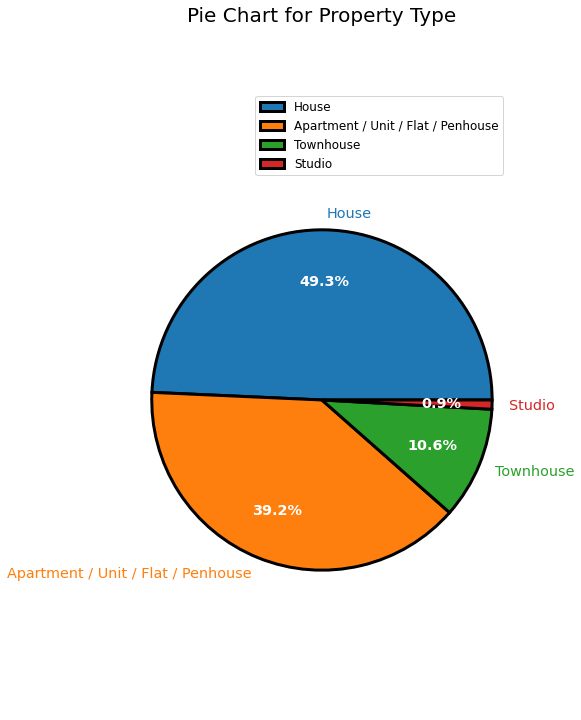

In [9]:
pie_data = Other_df['type'].value_counts()
labels = pie_data.index
sizes = pie_data.values
#get label and size
fig, ax = plt.subplots(figsize = (10,10))
#draw the pie char and modify the pie chart
patches, texts, pcts = ax.pie(pie_data ,explode=None,autopct='%1.1f%%',
                               pctdistance = 0.7, labels=labels,wedgeprops={'linewidth': 3.0, 'edgecolor': 'black'},
                               textprops={'size': 'x-large'})

plt.setp(pcts, color='white', fontweight='bold')  #label color
# face color.
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
plt.legend(labels,prop={'size': 12},bbox_to_anchor=(1.0, 1.0))
plt.title("Pie Chart for Property Type", x=0.5, y=1.1,fontsize=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

fig.figure.savefig('../plots/type_pie.png')

In [10]:
Other_df['type'] = Other_df['type'].replace('Apartment / Unit / Flat', 1)
Other_df['type'] = Other_df['type'].replace('Studio', 2)
Other_df['type'] = Other_df['type'].replace('Townhouse', 3)
Other_df['type'] = Other_df['type'].replace('House', 4)
Other_df['type'] = Other_df['type'].replace('Penthouse', 5)

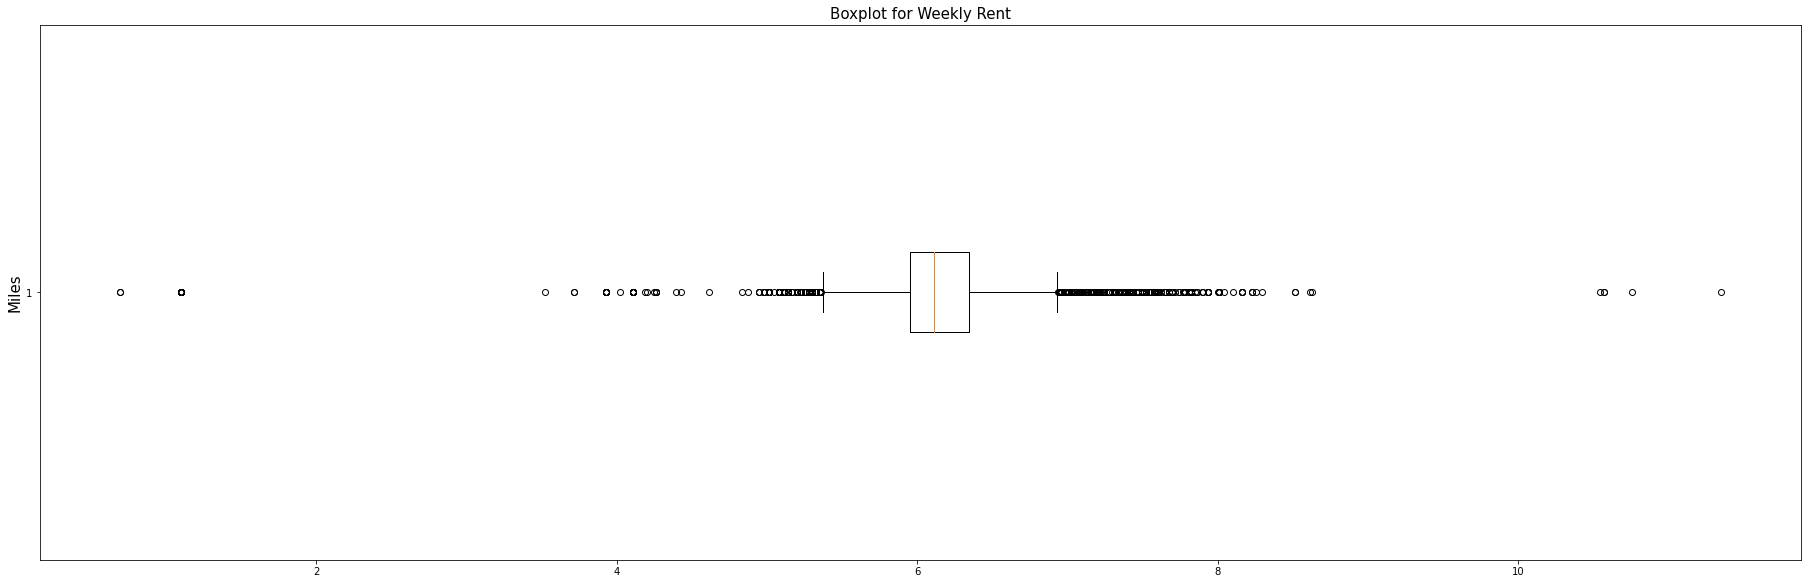

In [11]:
Other_df["log_rent"] = np.log1p(Other_df["rent_weekly"])  # np.log1p  log(1+x)

#Using Boxplot to find the outliers for numerical attributes
fig, axs = plt.subplots(1,1, figsize=(25,8),squeeze=False,constrained_layout = True)
axs[0,0].boxplot(Other_df["log_rent"], vert=False)
axs[0,0].set_title('Boxplot for Weekly Rent',fontsize=15)
axs[0,0].set_ylabel("Miles",fontsize=15)
plt.show()
fig.figure.savefig('../plots/boxplot_before.png')

In [13]:
Other_df['log_rent']

0        5.993961
1        5.860786
2        5.802118
3        6.398595
4        5.802118
           ...   
14500    6.311735
14501    6.311735
14502    6.089045
14503    6.364751
14504    6.111467
Name: log_rent, Length: 14505, dtype: float64

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(221)
plt.title('log_rent before clean', fontsize=18)
sns.distplot(Other_df['log_rent'])

In [ ]:
Other_df_temp = Other_df[Other_df["rent_weekly"] < 2000]
Other_df_temp = Other_df_temp.drop(columns=['log_rent'])
Other_df_temp['log_rent'] = np.log1p(Other_df_temp["rent_weekly"])  # np.log1p  log(1+x)
plt.figure(figsize=(20, 6))



plt.subplot(221)
plt.title('rent_weekly', fontsize=18)
sns.distplot(Other_df_temp['rent_weekly'])

plt.subplot(222)
plt.title('log_rent', fontsize=18)
sns.distplot(Other_df_temp['log_rent'])



In [ ]:
plt.subplot(221)
plt.title('rent_weekly', fontsize=18)
sns.distplot(Other_df_temp['rent_weekly'])

In [ ]:
#Using Boxplot to find the outliers for numerical attributes
fig, axs = plt.subplots(1,1, figsize=(25,8),squeeze=False,constrained_layout = True)
axs[0,0].boxplot(Other_df["rent_weekly"], vert=False)
axs[0,0].set_title('Boxplot for Weekly Rent',fontsize=15)
axs[0,0].set_ylabel("Miles",fontsize=15)
plt.show()
fig.figure.savefig('../plots/boxplot_before.png')

In [ ]:
Other_df_temp

In [ ]:
# Using Boxplot to find the outliers for numerical attributes
fig, axs = plt.subplots(1,1, figsize=(25,8),squeeze=False,constrained_layout = True)
axs[0,0].boxplot(Other_df_temp['log_rent'], vert=False)
axs[0,0].set_title('Boxplot for Weekly Rent',fontsize=15)
axs[0,0].set_ylabel("Miles",fontsize=15)
plt.show()
#fig.figure.savefig('../plots/boxplot_before.png')

In [ ]:
#Using Boxplot to find the outliers for numerical attributes
fig, axs = plt.subplots(1,1, figsize=(25,8),squeeze=False,constrained_layout = True)
axs[0,0].boxplot(Other_df_temp["rent_weekly"], vert=False)
axs[0,0].set_title('Boxplot for Weekly Rent',fontsize=15)
axs[0,0].set_ylabel("Miles",fontsize=15)
plt.show()
#fig.figure.savefig('../plots/boxplot_before.png')

In [ ]:
Other_df_temp["rent_weekly"].describe()